In [1]:
from scipy import io
from pathlib import Path
import numpy as np
import matplotlib.patches as mpatches

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearRegressionHMM
from dynamax.utils.plotting import gradient_cmap

In [2]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [20]:
def plot_emissions_and_states(emissions, most_likely_states, posterior, cmap, colors):
    
    plot_slice = (0, emissions.shape[0])
    emission_dim = emissions.shape[-1]
    time_bins = emissions.shape[0]
    state_probability_spread = posterior.smoothed_probs.T
    lim = 1.1 * max(abs(emissions).max(), 1)
    # lim = 1

    plt.figure(figsize=(8, 6))
    plt.suptitle("Emissions and Inferred States", y=1.01)

    # Plot number 1
    plt.subplot(211)

    im = plt.imshow(most_likely_states[None, :],
        aspect="auto",
        cmap=cmap,
        vmin=0,
        vmax=len(colors)-1,
        extent=(0, time_bins, -lim, (emission_dim)*lim)
    )

    values = np.unique(most_likely_states.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="State {l}".format(l=values[i]) ) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Most Likely Z")

    # emissions line
    for d in range(emission_dim):
        plt.plot(emissions[:,d] + lim * d, '-k')

    plt.xlim(plot_slice)
    plt.yticks([+1, 0, -1])


    # Plot number 2
    plt.subplot(212)
    plt.imshow(state_probability_spread, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
    plt.xlim(plot_slice)
    plt.ylabel("$z_{\\mathrm{inferred}}$")
    plt.yticks(ticks=range(state_probability_spread.shape[0]), labels=range(state_probability_spread.shape[0]))
    plt.xlabel("time")

    plt.show()

def plot_lps(lps): 
    plt.figure(figsize=(6, 3))
    # true_lp = true_arhmm.marginal_log_prob(true_params, emissions, inputs=inputs)
    plt.plot(lps, label="EM")
    # plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.legend(loc="lower right")
    plt.show()

def plot_validation(cross_valids, show_var = True, max_states = 7):
    avg_val_lls = cross_valids.mean(axis=1)
    plt.plot(range(2, max_states), avg_val_lls, '-ko')
    if show_var:
        for k, per_fold_val_lls in zip(range(2, max_states), cross_valids):
            plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
    plt.xticks(range(2, max_states))
    plt.xlabel("num states ($K$)")
    plt.ylabel("avg. validation log prob.")
    plt.show()

In [4]:
target = np.load("/home/rudra/Desktop/markov_models/synthetic_joystic/angles_10_sess_40_trials/ch_target.npy")
cursor = np.load("/home/rudra/Desktop/markov_models/synthetic_joystic/angles_10_sess_40_trials/ch_cursor.npy")

target = np.expand_dims(target, axis=2)
cursor = np.expand_dims(cursor, axis=2)
exp_bias = np.ones((10, 40, 1))

train_emissions = cursor
train_inputs = np.concatenate((target, exp_bias), axis=2)

train_emissions.shape, train_inputs.shape

((10, 40, 1), (10, 40, 2))

In [5]:
def train_arhmm(num_states, emission_dim, input_dim, train_emissions, train_inputs):
    # Initialize with K-Means
    lrhmm = LinearRegressionHMM(num_states, input_dim, emission_dim)
    params, props = lrhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=train_emissions)

    # Fit with EM
    fitted_params, lps = lrhmm.fit_em(params, props, train_emissions, inputs=train_inputs, num_iters=10000, verbose=False)

    return lrhmm, fitted_params, lps

In [6]:
all_models, all_params, all_lps = [], [], []

# num_states = 4
input_dim = 2
emission_dim = 1

min_state = 2
max_state = 7

for num_states in range(min_state, max_state):
    print(f'Training: {num_states} states')
    arhmm, fitted_params, lps = train_arhmm(num_states, emission_dim, input_dim, train_emissions, train_inputs)
    all_models.append(arhmm)
    all_params.append(fitted_params)
    all_lps.append(lps)

Training: 2 states
Training: 3 states
Training: 4 states
Training: 5 states
Training: 6 states


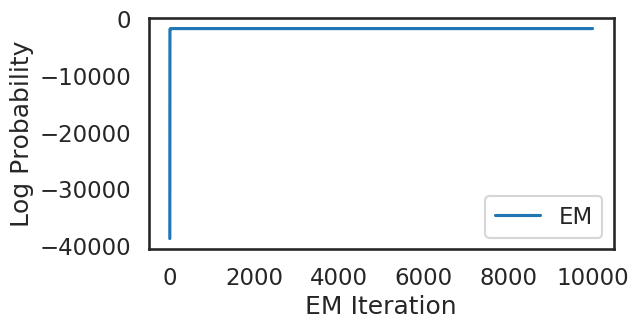

In [7]:
plot_lps(all_lps[4-2])

In [8]:
def cross_validate(all_models, all_params, emissions, inputs):
    cross_valids = []

    for model_idx in range(len(all_models)):
        print(f'Cross Validating: {model_idx} model')
        state_log_probs = []
        for validation_idx in range(len(emissions)):
            log_prob = all_models[model_idx].marginal_log_prob(all_params[model_idx], emissions[validation_idx], inputs=inputs[validation_idx])
            state_log_probs.append(float(log_prob))
        cross_valids.append(state_log_probs)

    return np.array(cross_valids)

Cross Validating: 0 model
Cross Validating: 1 model
Cross Validating: 2 model
Cross Validating: 3 model
Cross Validating: 4 model


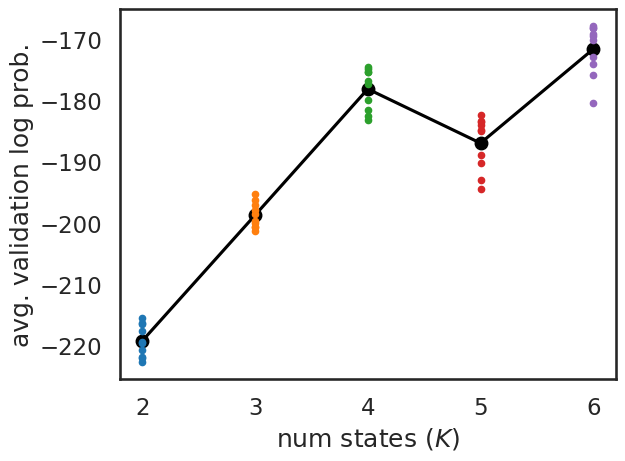

In [9]:
cross_train = cross_validate(all_models, all_params, train_emissions, train_inputs)
plot_validation(cross_valids=cross_train, show_var=True, max_states=max_state)

In [10]:
def inspect_sample(model_idx, em_idx):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    plot_emissions_and_states(train_emissions[em_idx], most_likely_states, posterior, cmap, colors)

# for i in range(2):
#     inspect_sample(4-2, i)

In [11]:
fourth = all_models[4 - 2]
p_fourth = all_params[4 - 2]

In [12]:
recovered_weights = fourth.observations.params

AttributeError: 'LinearRegressionHMM' object has no attribute 'observations'

In [13]:
p_fourth.transitions.transition_matrix

DeviceArray([[0.89042795, 0.06382545, 0.04453406, 0.00121259],
             [0.05233772, 0.49381992, 0.4262693 , 0.02757302],
             [0.05828658, 0.52907354, 0.33078328, 0.08185659],
             [0.00109536, 0.00110539, 0.00121104, 0.9965882 ]],            dtype=float32)

In [14]:
p_fourth.emissions.weights

DeviceArray([[[ 1.87334493e-02,  1.75794998e+02]],

             [[ 1.19592056e-01,  2.70300598e+01]],

             [[ 2.27184340e-01,  2.05961304e+02]],

             [[-1.17433714e-02,  5.26821411e+02]]], dtype=float32)

In [16]:
p_fourth.emissions.biases

DeviceArray([[   0.],
             [ 256.],
             [-128.],
             [-256.]], dtype=float32)

In [17]:
p_fourth.emissions.covs

DeviceArray([[[  29.738905]],

             [[ 320.42633 ]],

             [[2168.6633  ]],

             [[  18.385796]]], dtype=float32)

| state 1 | bias 0.0 | covs 29.73890495300293 |
--------------------------------------------------
| state 2 | bias 256.0 | covs 320.42633056640625 |
--------------------------------------------------
| state 3 | bias -128.0 | covs 2168.663330078125 |
--------------------------------------------------
| state 4 | bias -256.0 | covs 18.38579559326172 |
--------------------------------------------------


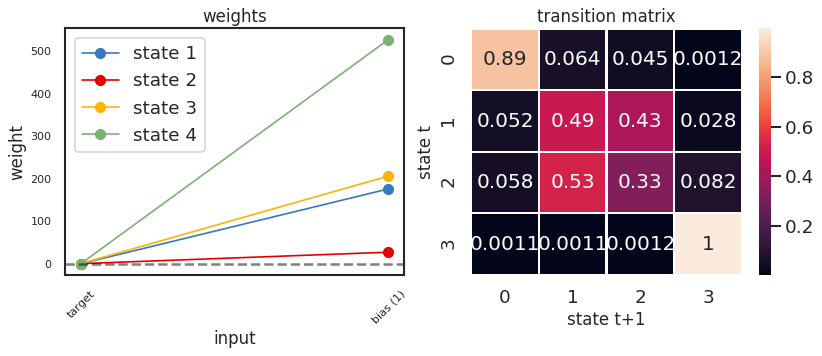

In [23]:
curr_states = 4

# Plot MLE parameters:
fig = plt.figure(figsize=(12*1, 4*1), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = colors
for k in range(curr_states):
    plt.plot(range(input_dim), p_fourth.emissions.weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("weight", fontsize=15)
plt.xlabel("input", fontsize=15)
plt.xticks([0, 1], ['target', 'bias (1)'], fontsize=10, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = p_fourth.transitions.transition_matrix
sns.heatmap(gen_trans_mat, annot=True, linewidths=1, linecolor='white', )
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("transition matrix", fontsize = 15)

bias = p_fourth.emissions.biases.reshape(-1).tolist()
covs = p_fourth.emissions.covs.reshape(-1).tolist()

for i in range(4):
    print("| state", i+1, "| bias", bias[i], "| covs", covs[i], "|")
    print("-"*50)

In [ ]:
# --- identities ---
# Previous emission choice (n-1)
# (n-2)
# (n-3)

# --- n_repetitions ---
# count of repetitions in n-3 buffer

# Cumulative previous motor bias (low resolution angle [quadrants]) (n-1)

# divided or focused attention
# Expectation bias
# global internal bias

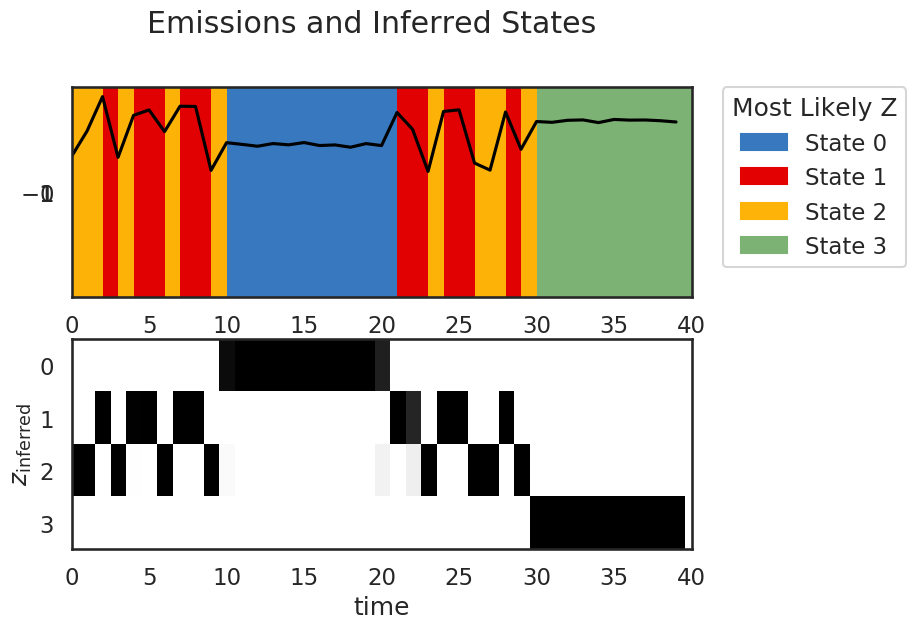

In [22]:
def inspect_sample(model_idx, em_idx):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    plot_emissions_and_states(train_emissions[em_idx], most_likely_states, posterior, cmap, colors)

for i in range(1): inspect_sample(4-2, i)